In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
m_train = 10000
X_train = np.zeros(shape=(10, m_train),dtype='int32')
y_train = np.zeros(shape=(2, m_train), dtype='int32')

for j in range(m_train):
    i = np.random.randint(0, X_train.shape[0])
    X_train[i, j] = 1
    y_train[i%2, j] = 1

In [4]:
m_test = 100
X_test = np.zeros(shape=(X_train.shape[0], m_test),dtype='int32')
y_test = np.zeros(shape=(y_train.shape[0], m_test), dtype='int32')

for j in range(m_test):
    i = np.random.randint(0, X_test.shape[0])
    X_test[i, j] = 1
    y_test[i%2, j] = 1

In [2]:
class NeuralNetwork:

    @staticmethod
    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    @staticmethod
    def sigmoid_prime(x):
        a = NeuralNetwork.sigmoid(x)
        return a * (1 - a)

    @staticmethod
    def softmax(x):
        # Stability fix: subtract max for numerical stability
        exp_shifted = np.exp(x - np.max(x, axis=0, keepdims=True))
        return exp_shifted / np.sum(exp_shifted, axis=0, keepdims=True)

    @staticmethod
    def cross_entropy_loss(y_true, y_pred):
        # Add epsilon to avoid log(0)
        eps = 1e-12
        return -np.sum(y_true * np.log(y_pred + eps)) / y_true.shape[1]

    @staticmethod
    def cross_entropy_derivative(y_true, y_pred):
        return y_pred - y_true

    def __init__(self, layer_sizes):
        self.costs = []
        self.iters = []
        self.weights = []
        self.biases = []
        self.Layers = len(layer_sizes)

        for k in range(self.Layers - 1):
            # Xavier initialization for sigmoid
            self.weights.append(np.random.randn(layer_sizes[k + 1], layer_sizes[k]) * np.sqrt(1. / layer_sizes[k]))
            self.biases.append(np.zeros((layer_sizes[k + 1], 1)))

    def forward(self, X):
        self.activations = [X]
        self.Z = []

        for i, (w, b) in enumerate(zip(self.weights, self.biases)):
            z = np.dot(w, self.activations[-1]) + b
            self.Z.append(z)

            if i == self.Layers - 2:
                a = NeuralNetwork.softmax(z)
            else:
                a = NeuralNetwork.sigmoid(z)

            self.activations.append(a)

        return self.activations[-1]

    def backward(self, X, y):
        dw = [None] * (self.Layers - 1)
        db = [None] * (self.Layers - 1)
        dz = [None] * (self.Layers)

        y_pred = self.activations[-1]
        cost = NeuralNetwork.cross_entropy_loss(y, y_pred)

        # Last layer derivative
        dz[-1] = NeuralNetwork.cross_entropy_derivative(y, y_pred)

        for l in reversed(range(self.Layers - 1)):
            a_prev = self.activations[l]
            dz_current = dz[l + 1]

            dw[l] = np.dot(dz_current, a_prev.T) / X.shape[1]
            db[l] = np.sum(dz_current, axis=1, keepdims=True) / X.shape[1]

            if l != 0:
                da_prev = np.dot(self.weights[l].T, dz_current)
                dz[l] = da_prev * NeuralNetwork.sigmoid_prime(self.Z[l - 1])

        return cost, dw, db

    def train(self, X, y, alpha=0.1, epochs=1000):
        for i in range(epochs):
            self.forward(X)
            cost, dw, db = self.backward(X, y)

            if i % (epochs // 10) == 0 or i == epochs - 1:
                self.costs.append(cost)
                self.iters.append(i)
                print(f"Epoch {i}, Cost: {cost:.4f}")

            for j in range(self.Layers - 1):
                self.weights[j] -= alpha * dw[j]
                self.biases[j] -= alpha * db[j]

    def predict(self, X):
        return self.forward(X)

    def evaluate(self, X, y_true):
        y_pred = self.forward(X)
        pred_labels = np.argmax(y_pred, axis=0)
        true_labels = np.argmax(y_true, axis=0)
        accuracy = np.mean(pred_labels == true_labels)
        return accuracy

In [14]:
model = NeuralNetwork([10, 2])
model.train(X_train, y_train, alpha=0.1, epochs=10000)
acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {acc * 100:.2f}%")

Epoch 0, Cost: 0.7275
Epoch 1000, Cost: 0.0537
Epoch 2000, Cost: 0.0264
Epoch 3000, Cost: 0.0174
Epoch 4000, Cost: 0.0130
Epoch 5000, Cost: 0.0103
Epoch 6000, Cost: 0.0086
Epoch 7000, Cost: 0.0073
Epoch 8000, Cost: 0.0064
Epoch 9000, Cost: 0.0057
Epoch 9999, Cost: 0.0051
Test Accuracy: 100.00%


<Axes: >

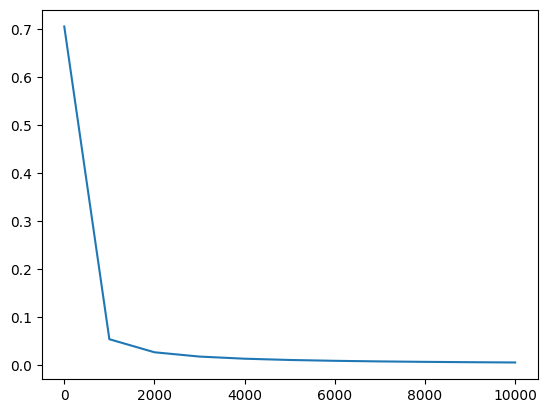

In [13]:
sns.lineplot(x=model.iters, y = model.costs)